In [1]:
import torch
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import silhouette_score

### Load SILVA data

In [2]:
# Heavy file, takes a minute
silva_db = pd.read_table('C:/Users/efrat/Downloads/silva_138_release/Exports/SILVA_parsed_V2.tsv', index_col = 0,
                        dtype={'raw_id': str, 
                               "full_taxonomy": str, 
                               "seq_length": int,
                               "seq": str, 
                               "kingdom": str, 
                               "phylum": str, 
                               "class": str, 
                               "order": str, 
                               "family": str,
                               "genus": str,
                               "species": str,
                               "strain": str})
silva_db.head()

,raw_id,full_taxonomy,seq_length,seq,kingdom,phylum,class,order,family,genus,species,strain
0,HG531388.1.1375,Bacteria;Proteobacteria;Alphaproteobacteria;Rh...,1375,AGUCGAGCGGGCGCAGCAAUGCGUCAGCGGCAGACGGGUGAGUAAC...,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Rhodoplanes,Rhodoplanes oryzae,NaN
1,HL281785.3.1301,Bacteria;Bacteroidota;Bacteroidia;Bacteroidale...,1299,AUUCCGGGAUAGCCUUUCGAAAGAAAGAUUAAUACUGGAUAGCAUA...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,unidentified,NaN
2,AB002644.1.1485,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,1485,GGCUAAUACAUGCAAGUCGAGCGAGUGAACAAACAGAAGCCUUCGG...,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,low G+C Gram-positive bacterium HTA454,NaN
3,AB002648.1.1383,Bacteria;Firmicutes;Bacilli;Thermoactinomyceta...,1383,AGCGGCGAACGGGUGAGUAACACGNGGGUAACCUGCCCUCAAGACC...,Bacteria,Firmicutes,Bacilli,Thermoactinomycetales,Thermoactinomycetaceae,Thermoflavimicrobium,low G+C Gram-positive bacterium HTA1422,NaN
4,JN049459.1.1443,Bacteria;Actinobacteriota;Actinobacteria;Strep...,1443,GACAUGGCGCCUCUACCAUGCAGUCGACGAUGACCACCUUCGGGGU...,Bacteria,Actinobacteriota,Actinobacteria,Streptomycetales,Streptomycetaceae,Streptomyces,actinobacterium ZXY010,NaN


In [3]:
len(silva_db)

432033

### Load sequence-level embeddings

In [4]:
bpe_embed_path = "C:/Users/efrat/Documents/DNA_BERT_Data/bert_embeddings/averaged_embeddings_no_padding"
kmer_embed_path = "C:/Users/efrat/Documents/DNA_BERT_Data/bert_embeddings/averaged_embeddings_6mer"

In [5]:
bpe_seq_embed = torch.load(bpe_embed_path)
bpe_seq_embed.shape

torch.Size([432033, 256])

In [6]:
kmer_seq_embed = torch.load(kmer_embed_path)
kmer_seq_embed.shape

torch.Size([432033, 256])

In [7]:
# Column names for embedding digits
feat_cols = [ 'emb'+str(i) for i in range(bpe_seq_embed.shape[1]) ]

# Convert into one data frame
df_bpe = pd.DataFrame(bpe_seq_embed.numpy(), columns = feat_cols)

# Add tax' info from silva_db
df_bpe['phylum'] = silva_db['phylum']
df_bpe['class'] = silva_db['class']
df_bpe['order'] = silva_db['order']
df_bpe['family'] = silva_db['family']
df_bpe['genus'] = silva_db['genus']

# Same for k-mers
df_kmer = pd.DataFrame(kmer_seq_embed.numpy(), columns = feat_cols)
df_kmer['phylum'] = silva_db['phylum']
df_kmer['class'] = silva_db['class']
df_kmer['order'] = silva_db['order']
df_kmer['family'] = silva_db['family']
df_kmer['genus'] = silva_db['genus']

print('Size of the bpe dataframe: {}'.format(df_bpe.shape))
print('Size of the 6-mer dataframe: {}'.format(df_bpe.shape))

Size of the bpe dataframe: (432033, 261)
Size of the 6-mer dataframe: (432033, 261)


### PCA/t-SNE preparations

To make our plots more readable, we remove rare phyla (500 representative sequences or less) from our data

In [57]:
# Choose taxonomic-level for visualization
tax_level = "genus"
rare_threshold = 100

df_bpe = df_bpe.groupby(tax_level).filter(lambda x: len(x) > rare_threshold)
df_bpe = df_bpe.reset_index(drop=True)
print('Size of the bpe dataframe after removing rare taxa: {}'.format(df_bpe.shape))

# Same for k-mers
df_kmer = df_kmer.groupby(tax_level).filter(lambda x: len(x) > rare_threshold)
df_kmer = df_kmer.reset_index(drop=True)
print('Size of the k-mer dataframe after removing rare taxa: {}'.format(df_kmer.shape))

Size of the bpe dataframe after removing rare taxa: (307908, 276)
Size of the k-mer dataframe after removing rare taxa: (307908, 276)


In order not to run all calculations on the entire ~0.5M dataset (t-SNE isn't recommended for more than 10K samples), we will use just a random subset of data. We create a random ordering of the rows to ensure the subset we take is random. 

In [58]:
np.random.seed(42) # For reproducability 
rndperm = np.random.permutation(df_bpe.shape[0])
print('Sanity: permuted row ordering has length', len(rndperm))

Sanity: permuted row ordering has length 307908


In [59]:
N = 20000
df_bpe_subset = df_bpe.loc[rndperm[:N],:].copy()
df_kmer_subset = df_kmer.loc[rndperm[:N],:].copy()

# How many colors will be needed?
n_taxa = df_bpe_subset[tax_level].nunique()

print(n_taxa,"colors will be used to visualize",tax_level,"-level labels, using only the first", N, "sequences in the data")

473 colors will be used to visualize genus -level labels, using only the first 20000 sequences in the data


#### PCA

For PCA we use all data points.

In [60]:
# BPE tokens-based PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(df_bpe[feat_cols].values) # -or- df_bpe_subset
for i in range(10):
    df_bpe['pca'+str(i+1)] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Overall variance explained by 10 PCA components:', sum(pca.explained_variance_ratio_))

Explained variation per principal component: [0.40569478 0.06705928 0.04573423 0.03369277 0.02807299 0.02733507
 0.02174292 0.02103259 0.01775302 0.01560382]
Overall variance explained by 10 PCA components: 0.6837214781082667


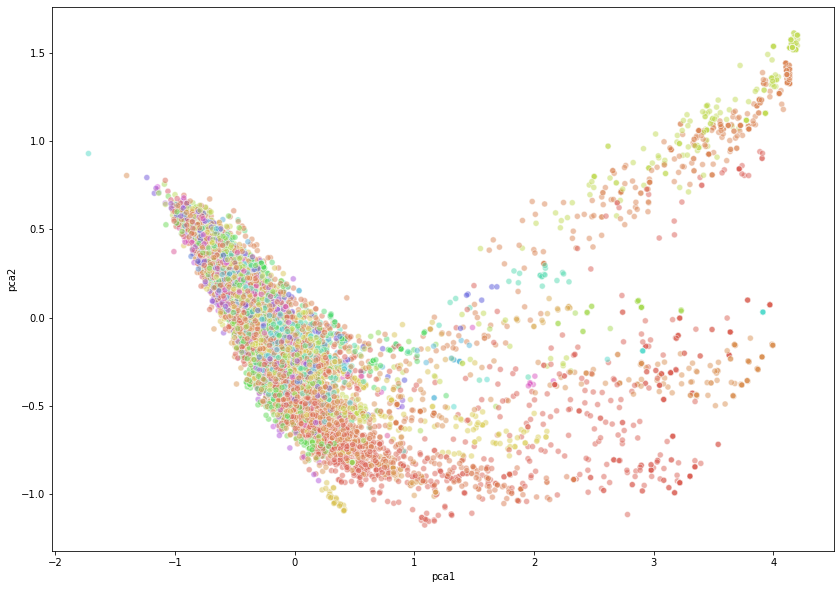

In [61]:
plt.figure(figsize=(14,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_bpe.loc[rndperm[:N],:], # -or- df_bpe_subset
    legend=False,
    alpha=0.5
)

In [62]:
# K-mer tokens-based PCA
pca2 = PCA(n_components = 10)
pca_result2 = pca2.fit_transform(df_kmer[feat_cols].values) # -or- df_bpe_subset
for i in range(10):
    df_kmer['pca'+str(i+1)] = pca_result2[:,i]
print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))
print('Overall variance explained by 10 PCA components:', sum(pca2.explained_variance_ratio_))

Explained variation per principal component: [0.14638867 0.09223552 0.07215728 0.04888806 0.04558856 0.03972058
 0.03752198 0.03284511 0.02714513 0.02475911]
Overall variance explained by 10 PCA components: 0.5672500061214376


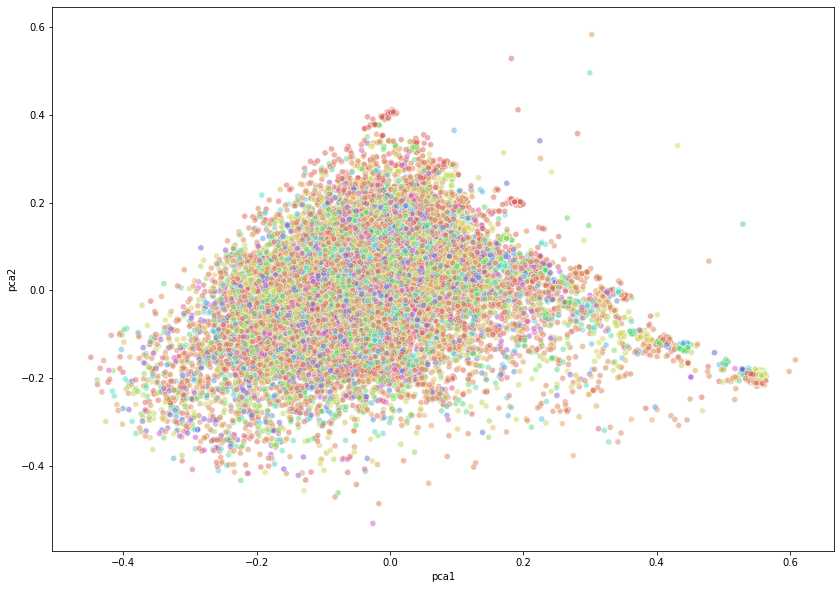

In [63]:
plt.figure(figsize=(14,10))
sns.scatterplot(
    x="pca1", y="pca2",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_kmer.loc[rndperm[:N],:], # -or- df_kmer_subset
    legend=False,
    alpha=0.5
)

We compute the silhouette score for each pca to see if one better seperates phyla than the other

In [64]:
silhouette_avg_bpe = silhouette_score(X = df_bpe[['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10']].values, 
                                      labels = df_bpe[tax_level], 
                                      sample_size = 50000, 
                                      random_state = 27)
print("For BPE tokens, the average silhouette_score is :", silhouette_avg_bpe)

For BPE tokens, the average silhouette_score is : -0.18583694


In [65]:
silhouette_avg_kmer = silhouette_score(X = df_kmer[['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10']].values, 
                                       labels = df_kmer[tax_level], 
                                       sample_size = 50000, 
                                       random_state = 27)
print("For k-mer tokens, the average silhouette_score is :", silhouette_avg_kmer)

For k-mer tokens, the average silhouette_score is : -0.2077146


#### T-Distributed Stochastic Neighbouring Entities (t-SNE)

An important note about t-SNE caveats: https://distill.pub/2016/misread-tsne/

For t-SNE we use a random subset of 10K sequences

In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_bpe_subset[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Extract t-SNE results and add to table
df_bpe_subset['tsne-2d-one'] = tsne_results[:,0]
df_bpe_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 1.906s...
[t-SNE] Computed neighbors for 20000 samples in 213.498s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

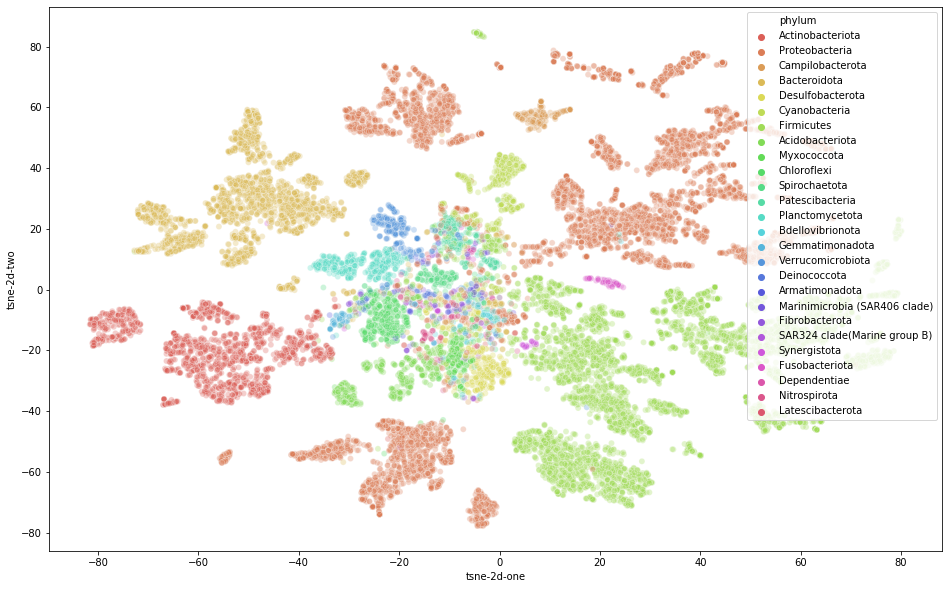

In [18]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_bpe_subset,
    legend="full",
    alpha=0.3
)

In [19]:
# Same for k-mers
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_kmer_subset[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Extract t-SNE results and add to table
df_kmer_subset['tsne-2d-one'] = tsne_results[:,0]
df_kmer_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 1.960s...
[t-SNE] Computed neighbors for 20000 samples in 231.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

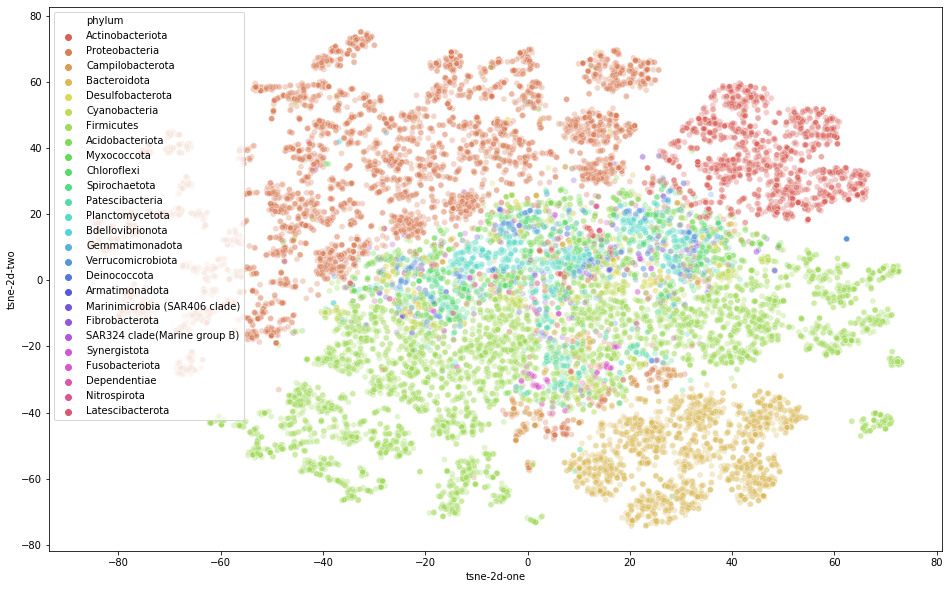

In [20]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tax_level,
    palette=sns.color_palette("hls", n_taxa),
    data=df_kmer_subset,
    legend="full",
    alpha=0.3
)